# Generating Bored Ape Yacht Club images

**The goal of this notebook is to create new Bored Ape Yacht Club images, using a Deep Convolutional Generative Adversarial Network learning to reproduce the existing images.**

The approach is the same that in my previous work on reproducing Anime Faces: https://www.kaggle.com/code/nassimyagoub/gan-anime-faces

This dataset contains bigger images, making the learning process computationally more expensive.

### Import libraries and loading data

In [2]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [3]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
# We reduce image size to 256x256 for complexity reasons
def load_images(directory='', size=(128,128)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    c = 0
    for path in imagePaths:
        c+=1
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
        if c > 10000:
            break
    
    return images

In [4]:
images=load_images('./archive/bayc')

### Let's look at some Apes

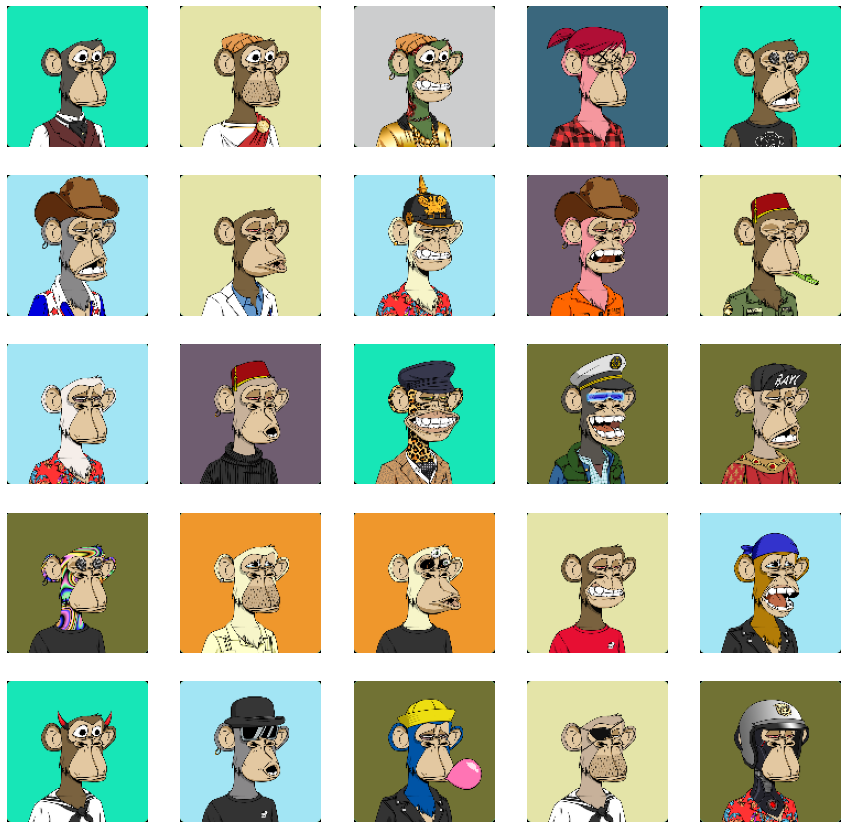

In [5]:
_,ax = plt.subplots(5,5, figsize = (15,15)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

These images are generated by combining features on the same base ape, we can see several of those features in the examples above: 3D glasses, wide smile, beard, red eyes etc.

**A perfect generation work would be to generate images combining those features in a new way.**

### Functionning of Generative Adversarial Networks

**A few years ago Yann LeCun described GANs as “the most interesting idea in the last 10 years in Machine Learning”.**

GANs are based on a fascinating concept of two Networks competing one against the other, making progress along the way.

#### The Generator

The first Network is a **Generator**, the goal of this network is to generate images consistent with the dataset we want to copy, in our case we want our generator to create new Bored Apes images. In order to generate different images, we use a random noise vector as the input of the network, the network should generate apes with any input, but different noise vectors should lead to different apes.

In a simplified way, after the training each dimension will correspond to a feature of the image, for example the hair shape of the character.

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="800px">

#### The Discriminator

The second Network is a **Discriminator**, the goal of the discriminator is to differentiate real images from fake generated ones. 

<img src="https://www.researchgate.net/profile/Jose-Benitez-Andrades/publication/339447623/figure/fig2/AS:862056077082627@1582541593714/A-vanilla-Convolutional-Neural-Network-CNN-representation.png" width="800px">

#### Training the GAN

Training a Generative Adversarial Network consists in:
* Generating a batch of noise vectors
* Using those vectors to generate fake images with the generator
* Creating a batch containing half real and half generated images
* Training the discriminator on those images with 2 output neurons (real vs generated)
* Training the generator using backpropagation on the loss of the discriminator (what should be changed to trick the discriminator ?)


In order to train a GAN, we need both networks to **compete evenly**, if the discriminator is too strong and can easily differentiate real and fake images then the generator will have too big of a gap to overcome and the training will be very slow. On the contrary if the discriminator is too weak and is unable to differentiate real and fake images then the generator has nothing more to learn, either the training is usccessful and the generation is perfect, or the generation is bad but has no way to progress.

## Creating the GAN

In [6]:
class GAN():
    def __init__(self):
        self.img_shape = (128, 128, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    def build_discriminator(self):
        
        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
        
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(8*8*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((8, 8, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)
    
    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)
            
            """p = np.random.permutation(batch_size)
            disc_input = np.concatenate([imgs,gen_imgs])[p]
            disc_output = np.concatenate([np.ones((half_batch, 1)), np.zeros((half_batch, 1))])[p]

            # Training the discriminator
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = self.discriminator.train_on_batch(disc_input, disc_output)"""
            
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator more than the discriminator because
            # the discriminator is having a very high accuracy
            for _ in range(3):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * (batch_size))
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)
                
    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(2,5, figsize = (15,6))

        for i in range(2):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("BoredApes/Images_%d.png" % epoch)
        plt.close()
        

In [7]:
!mkdir BoredApes

## Training the model

2022-06-08 14:34:15.717974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                        

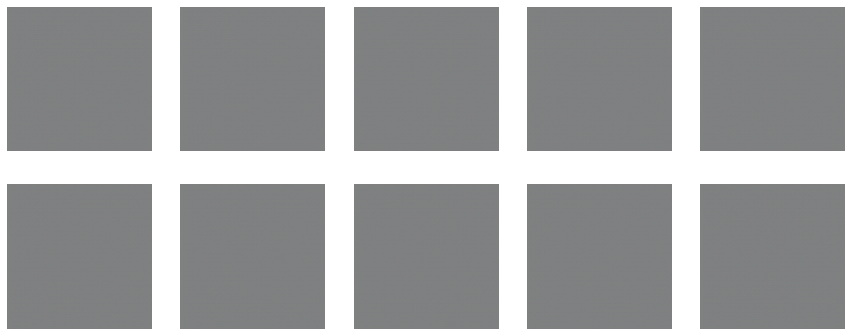

INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: generator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


INFO:tensorflow:Assets written to: discriminator_0/assets


2/2 [==============================] - 4s 2s/step


In [8]:
gan=GAN()
gan.train(epochs=5001, batch_size=128, metrics_update=100, save_images=200, save_model=5000)

We can see the network progress and a few images are convincing but we are still far from our initial goal.

We struggle to avoid **mode collapse**, which is a state in which every generator input leads to the same result.

Some of our limitations are due to our network, which is quite simple and small with current standards. Next time we will use a GAN architecture closer to the state of the art.